In [10]:
import numpy as np
import pandas as pd
import GPy
from sklearn.linear_model import BayesianRidge

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from pandas.plotting import parallel_coordinates

from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch

In [11]:
from oadap.prediction.utils import RMSE, chauvenet

In [12]:
df = pd.read_csv('../../data/MWRA/MWRA_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.columns

Index(['Station', 'Latitude', 'Longitude', 'Depth', 'Temperature', 'Salinity',
       'Oxygen', 'Fluorescence', 'TA', 'TCO2', 'pH', 'Ar', 'Date', 'Time',
       'SST', 'Surface Chlorophyll', 'Surface Kd490', 'Surface Salinity',
       'TA (Prediction)', 'TA (Std. Dev.)'],
      dtype='object')

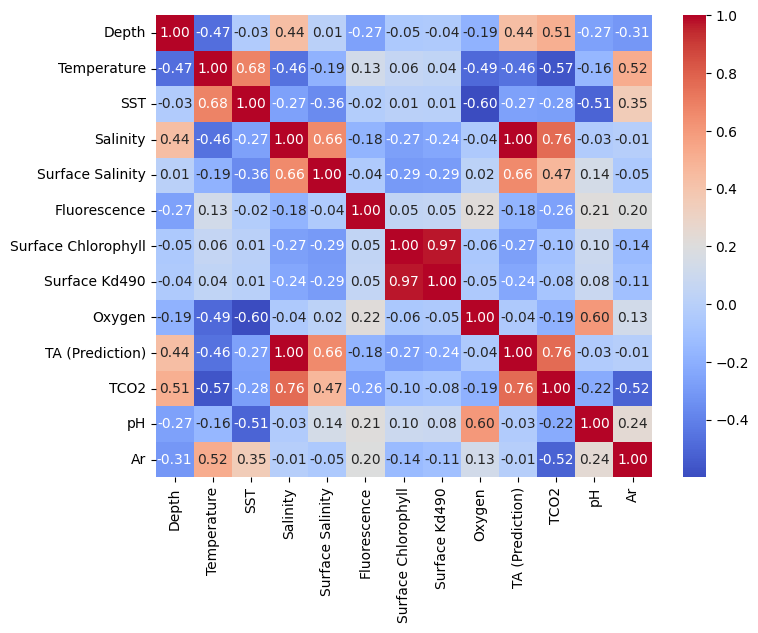

In [13]:
# Calculating correlation matrix
correlation_matrix = df[['Depth', 'Temperature', 'SST', 'Salinity','Surface Salinity',
                             'Fluorescence', 'Surface Chlorophyll', 'Surface Kd490', 'Oxygen', 
                            'TA (Prediction)', 'TCO2', 'pH', 'Ar']].corr()

# Plotting correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


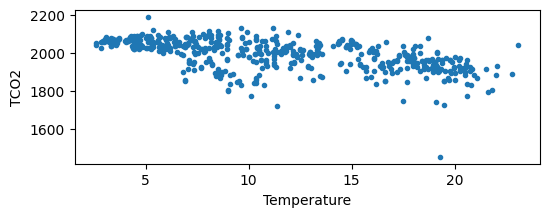

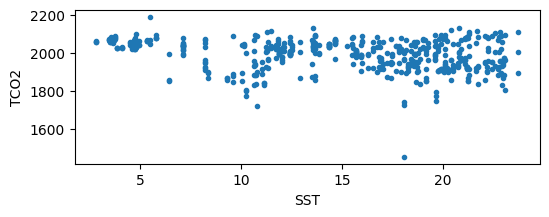

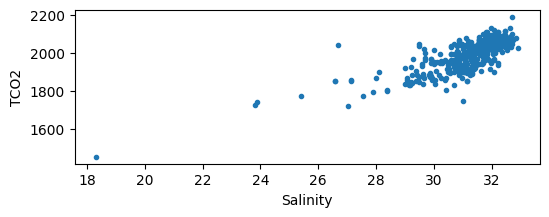

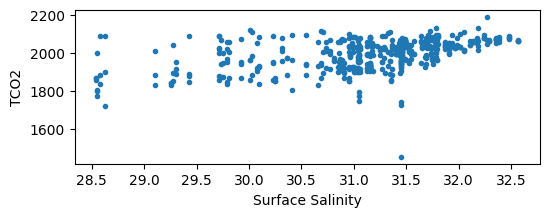

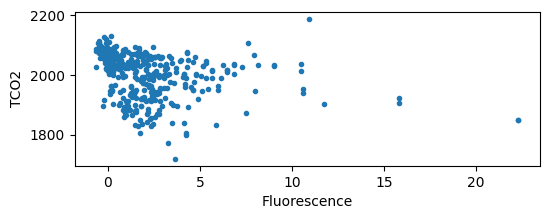

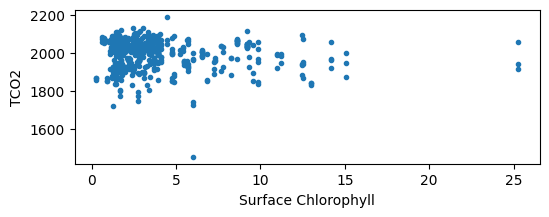

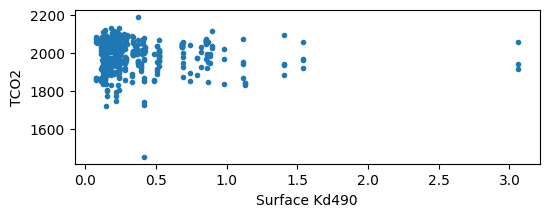

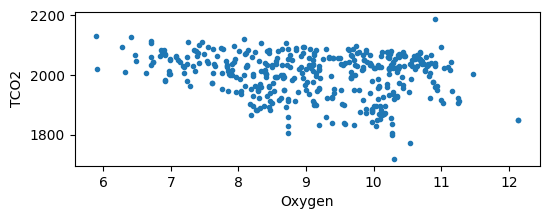

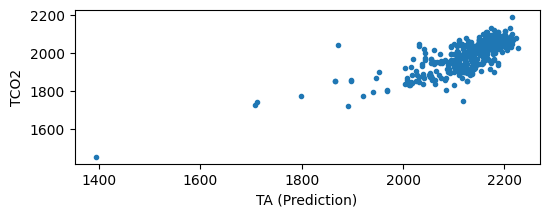

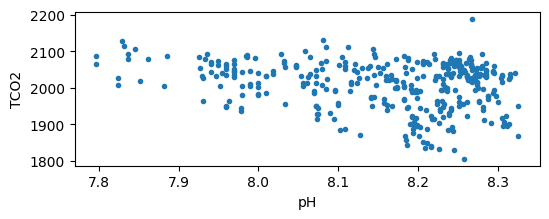

In [14]:
v = 'TCO2'

regressors = ['Temperature','SST','Salinity', 'Surface Salinity',
        'Fluorescence',   'Surface Chlorophyll', 'Surface Kd490', 'Oxygen',
       'TA (Prediction)', 'pH']

for r in regressors:
    plt.figure(figsize=(6,2))
    plt.plot(df[r], df[v], '.')
    plt.xlabel(r)
    plt.ylabel(v)

In [15]:
df[['Depth', 'Temperature', 'Salinity','Surface Chlorophyll', 'Fluorescence']]

,Depth,Temperature,Salinity,Surface Chlorophyll,Fluorescence
0,1.61,3.386,32.52,2.439166,2.137
1,5.63,3.425,32.52,2.439166,9.371
2,11.00,3.592,32.55,2.439166,6.480
3,16.75,3.690,32.57,2.439166,4.057
4,22.79,3.794,32.59,2.439166,3.527
...,...,...,...,...,...
4409,2.26,14.800,31.31,1.462361,1.660
4410,7.97,14.340,31.69,1.462361,0.860
4411,13.81,14.160,31.83,1.462361,0.750
4412,19.14,13.830,32.01,1.462361,0.680


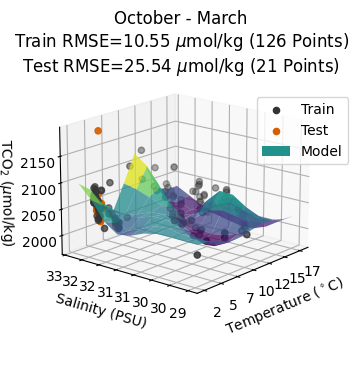

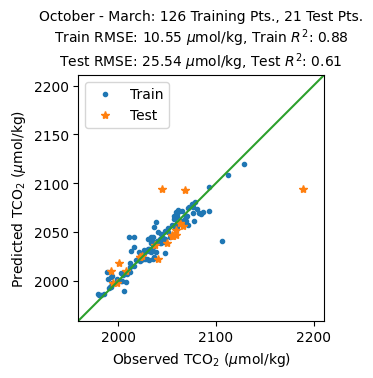

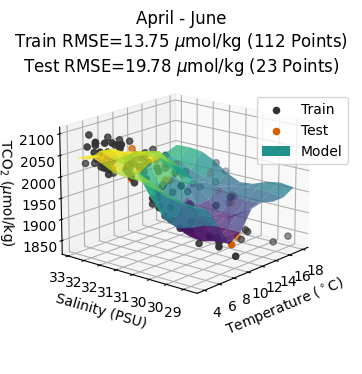

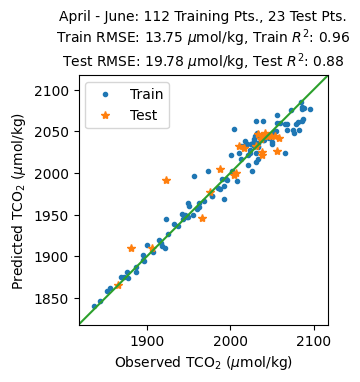

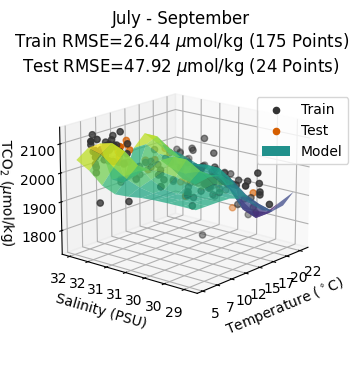

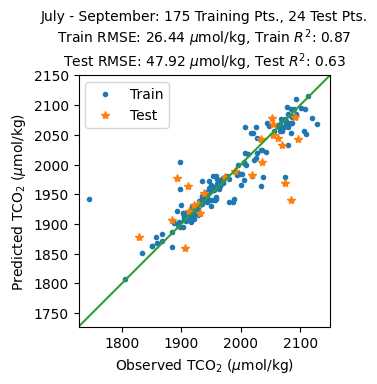

In [21]:
MWRA = df.copy()

v = 'TCO2'
test_s = 'F06'

linear = False
optimize = False

cmap = plt.cm.viridis

regressors = ['Temperature', 'Salinity', 'Surface Chlorophyll']
units = {'Temperature': '$^\circ$C', 'Salinity': 'PSU', 'Surface Chlorophyll': 'mg/m$^-3$', 'TCO2': '$\mu$mol/kg'}

nr = len(regressors)

for r in regressors:
    MWRA = MWRA[~np.isnan(MWRA[r])]
    MWRA = MWRA.loc[chauvenet(MWRA[r])]

checkpoint = {}

seasons = {0: 'October - March', 1: 'April - June', 2:'July - September'}
seasons_idx = [[10,11,2,3], [4,5,6], [7,8,9]]
# seasons = {0: 'Jan-Dec'}
# seasons_idx = [np.arange(1,12)]
ns = len(seasons_idx)

for j in range(ns): 
    df_d = MWRA[(MWRA['Date'].dt.month).isin(seasons_idx[j])].copy()
    df_d = df_d[~np.isnan(df_d[v])]

    Xm = np.array(df_d[regressors].mean(axis=0))
    Xs = np.array(df_d[regressors].std(axis=0))
    df_d[regressors] = (df_d[regressors] - Xm) / Xs
    
    ym = df_d[v].mean()
    ys = df_d[v].std()
    df_d[v] = (df_d[v] - ym) / ys

    df_train = df_d[~(df_d['Station']==test_s)]
    df_test = df_d[df_d['Station']==test_s]

    # n_points = len(df_d)
    # df_test = df_d.sample(int(0.3*n_points))
    # df_train = df_d.drop(df_test.index)

    X_train = np.array(df_train[regressors])
    y_train = np.array(df_train[v])
    X_test = np.array(df_test[regressors])
    y_test = np.array(df_test[v])
    
    
    if linear:
        model = BayesianRidge().fit(X_train, y_train)
        y_pred_train, y_var_train = model.predict(X_train, return_std=True)
        y_var_train = y_var_train**2
        y_pred_test, y_var_test = model.predict(X_test, return_std=True)
        y_var_test = y_var_test**2
    else:
        kernel = GPy.kern.RBF(X_train.shape[1], ARD=True)
        model = GPy.models.GPRegression(X_train, np.atleast_2d(y_train).T, kernel)
        
        if optimize:
            # opt_param = model.optimize_restarts(messages=False, verbose=False)
            opt_param = model.optimize()
            print(np.array(model.rbf.lengthscale))
            print(np.array(model.rbf.variance))
            print(np.array(model.Gaussian_noise.variance))
        else:
            if len(regressors) == 4:
                model.rbf.lengthscale.fix([1, 0.5, 1, 1])
            else:
                model.rbf.lengthscale.fix([0.5, 1, 1])
            model.rbf.variance.fix(1.3)
            model.Gaussian_noise.variance.fix(0.05)

        y_pred_train, y_var_train = model.predict(X_train)
        y_pred_test, y_var_test = model.predict(X_test)
    
    checkpoint[seasons[j]] = {"model": model, "Xm": Xm, "Xs": Xs, "ym": ym, "ys": ys}
    
    y_pred_train = y_pred_train * ys + ym
    y_pred_test = y_pred_test * ys + ym

    y_train = y_train * ys + ym
    y_test = y_test * ys + ym



    ttl = seasons[j]
    ttl1 = str(len(df_train[v])) + ' Training Pts., ' + str(len(df_test[v])) + ' Test Pts.'
    
    train_rmse =  str(np.round(np.sqrt(mean_squared_error(y_train, y_pred_train.reshape(y_train.shape))),2))
    train_r2 = str(np.round(r2_score(y_train, y_pred_train.reshape(y_train.shape)),2))
    test_rmse = str(np.round(np.sqrt(mean_squared_error(y_test, y_pred_test.reshape(y_test.shape))),2))
    test_r2 = str(np.round(r2_score(y_test, y_pred_test.reshape(y_test.shape)),2))
    
    ttl2 = 'Train RMSE: ' + train_rmse + ' $\mu$mol/kg, Train $R^2$: ' + train_r2
    ttl3 = 'Test RMSE: ' +  test_rmse + ' $\mu$mol/kg, Test $R^2$: ' + test_r2

    ttl4 =  'Train RMSE=' + train_rmse + ' $\mu$mol/kg (' + str(len(df_train[v])) + ' Points)'  
    ttl5 =  'Test RMSE=' + test_rmse + ' $\mu$mol/kg (' + str(len(df_test[v])) + ' Points)'  
    

    # plt.figure(figsize=(nr*3,2))
    # for ir, r in enumerate(regressors):
    #     plt.subplot(1,nr,ir+1)
    #     if linear:
    #         X_test2 = np.linspace(df_d[r].min(), df_d[r].max(), 100)
    #         y_test2 = model.coef_[ir]*X_test2 + model.intercept_
    #         y_test2 = y_test2 * ys + ym
    #         X_test2 = X_test2 * Xs[ir] + Xm[ir]
    #         plt.plot(X_test2, y_test2, label='model')
    #     else:
    #         X_test2 = np.zeros((100,nr))
    #         for k in range(nr):
    #             if k == ir:
    #                 X_test2[:,k] = np.linspace(df_d[r].min(), df_d[r].max(), 100)
    #             else:
    #                 X_test2[:,k] = np.mean(df_d[regressors[k]])*np.ones((100,))
    #         y_test2, y_var2 = model.predict(X_test2)
    #         y_test2 = y_test2 * ys + ym
    #         y_std2 = np.sqrt(y_var2 * (ys**2))
    #         X_test2 = X_test2 * Xs + Xm
    #         plt.plot(X_test2[:,ir], y_test2, label='model')
    #         plt.fill_between(X_test2[:,ir].flatten(), y_test2.flatten()+y_std2.flatten(), y_test2.flatten()-y_std2.flatten(), alpha=0.2)            
        
    #     plt.plot(df_train[r]*Xs[ir]+Xm[ir], y_train, '.', label='True (train)')
    #     plt.plot(df_test[r]*Xs[ir]+Xm[ir], y_test, '.', label='True (test)')
    #     plt.xlabel(r)
    #     plt.ylabel(v)
    #     plt.legend()
    #     plt.tight_layout()

    if not linear:
        # for ir in range(3):
        for ir in range(1):
            r1 = regressors[np.mod(ir,3)]
            r2 = regressors[np.mod(ir+1,3)]
            X1_linspace = np.linspace(X_train[:,np.mod(ir,3)].min(), X_train[:,np.mod(ir,3)].max(), 10)
            X2_linspace = np.linspace(X_train[:,np.mod(ir+1,3)].min(), X_train[:,np.mod(ir+1,3)].max(), 10)
            X1_grid, X2_grid = np.meshgrid(X1_linspace, X2_linspace)

            model1 = BayesianRidge().fit(X_train[:,[np.mod(ir,3), np.mod(ir+1,3)]], X_train[:,np.mod(ir+2,3)])
            X3_grid = model1.predict(np.array([X1_grid.reshape(-1), X2_grid.reshape(-1)]).T)
            # X3_grid = np.ones(X1_grid.reshape(-1).shape)*(X_train[:,np.mod(ir+2,3)].mean())
            
            X_grid = (np.array([X1_grid.reshape(-1), X2_grid.reshape(-1), X3_grid])).T
            
            y_grid, y_var_grid = model.predict(X_grid)
            y_grid = y_grid.reshape(X1_grid.shape)
            y_var_grid = y_var_grid.reshape(X1_grid.shape)

            y_grid = y_grid * ys + ym
            y_var_grid = y_var_grid * (ys**2)
            y_std_grid = np.sqrt(y_var_grid)

            X1_grid = X1_grid * Xs[np.mod(ir,3)] + Xm[np.mod(ir,3)]
            X2_grid = X2_grid * Xs[np.mod(ir+1,3)] + Xm[np.mod(ir+1,3)]
            X_train_denorm = X_train * Xs + Xm
            X_test_denorm = X_test * Xs + Xm

            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111, projection='3d', position=[0.1, 0.1, 0.8, 0.8])
            ax.plot_surface(X1_grid, X2_grid, y_grid, cmap=cmap, alpha=0.75)

            idx = np.argwhere(y_train>1700)
            idx_test = np.argwhere(y_test>1700)
            # ax.scatter(X_train_denorm[idx,np.mod(ir,3)], X_train_denorm[idx,np.mod(ir+1,3)], y_train[idx], c=y_train[idx])
            train_plt = ax.scatter(X_train_denorm[idx,np.mod(ir,3)], X_train_denorm[idx,np.mod(ir+1,3)], y_train[idx], c='#333333', label='Train')
            test_plt = ax.scatter(X_test_denorm[idx_test,np.mod(ir,3)], X_test_denorm[idx_test,np.mod(ir+1,3)], y_test[idx_test], c='#D55E00', label='Test')

            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))
            
            ax.view_init(elev=17., azim=220)
            ax.set_xlabel(r1+' ('+units[r1]+')', labelpad=7)
            ax.set_ylabel(r2+' ('+units[r2]+')', labelpad=7)
            ax.set_zlabel('TCO$_2$ ($\mu$mol/kg)', labelpad=7)
            ax.set_box_aspect(aspect=None, zoom=0.8)
            title_obj = ax.set_title(ttl+ '\n' + ttl4 + '\n' + ttl5, y=0.9)

            
            legend_elements = [train_plt, test_plt, Patch(facecolor=cmap(0.5), edgecolor=None, label='Model')]
            ax.legend(handles=legend_elements, bbox_to_anchor=(0.7, 0.8), loc='upper left')
            
            plt.tight_layout()
            # fig.savefig('../Figures/DIC-'+seasons[j]+'-surface.png', dpi=1000, bbox_inches='tight')
            # fig.savefig('../Figures_PDF/DIC-'+seasons[j]+'-surface.pdf', dpi=300, bbox_inches='tight')

        

    min_val = 0.99*min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
    max_val = 1.01*max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())
    fig, ax = plt.subplots(figsize=(3.5,4))
    ax.plot(y_train, y_pred_train,'.', label='Train')
    ax.plot(y_test, y_pred_test, '*', label='Test')
    ax.plot(np.linspace(min_val, max_val), np.linspace(min_val, max_val))
    plt.xlabel('Observed TCO$_2$ ($\mu$mol/kg)')
    plt.ylabel('Predicted TCO$_2$ ($\mu$mol/kg)')
    plt.title(ttl + ': ' + ttl1 + '\n' + ttl2 + '\n' + ttl3, fontsize=10)
    plt.xlim([min_val, max_val])
    plt.ylim([min_val, max_val])
    ax.set_aspect('equal', adjustable='box')
    plt.legend()
    plt.tight_layout()
    # fig.savefig('../Figures/DIC-'+seasons[j]+'-R2.png', dpi=1000, bbox_inches='tight')
    # fig.savefig('../Figures_PDF/DIC-'+seasons[j]+'-R2.pdf', dpi=300, bbox_inches='tight')

    idx_all = df[regressors].notnull().all(axis=1) & (df['Date'].dt.month).isin(seasons_idx[j])
    X_all = np.array(df[idx_all][regressors])
    X_all = (X_all - Xm) / Xs
    if linear:
        y_pred_all, y_std_all = model.predict(X_all, return_std=True)
    else:
        y_pred_all, y_std_all = model.predict(X_all)
        y_std_all = np.sqrt(y_std_all)
        
    y_pred_all = y_pred_all * ys + ym
    y_std_all = y_std_all * ys
    df.loc[idx_all, v+' (Prediction)'] = y_pred_all
    df.loc[idx_all, v+' (Std. Dev.)'] = y_std_all



    
    


In [24]:
joblib.dump(checkpoint, '../checkpoints/DIC_regression/model.pkl')

['../checkpoints/DIC_regression/model.pkl']

In [19]:
import joblib

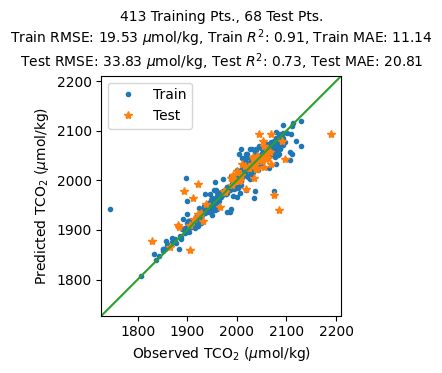

In [17]:
# data = df[(df['Date'].dt.month).isin(np.arange(2,11))].copy()
data = df.copy()

for r in regressors:
    data = data[~np.isnan(data[r])]
    data = data.loc[chauvenet(data[r])]
data = data[~np.isnan(data[v])]

df_train = data[~(data['Station']==test_s)]    
df_test = data[data['Station']==test_s]

y_train = np.array(df_train[v])
y_pred_train = np.array(df_train[v+' (Prediction)'])
y_test = np.array(df_test[v])
y_pred_test = np.array(df_test[v+' (Prediction)'])

ttl1 = str(len(df_train[v])) + ' Training Pts., ' + str(len(df_test[v])) + ' Test Pts.'

train_rmse =  str(np.round(np.sqrt(mean_squared_error(y_train, y_pred_train.reshape(y_train.shape))),2))
train_mae = str(np.round(np.mean(np.abs(y_train - y_pred_train.reshape(y_train.shape))),2))
train_r2 = str(np.round(r2_score(y_train, y_pred_train.reshape(y_train.shape)),2))
test_rmse = str(np.round(np.sqrt(mean_squared_error(y_test, y_pred_test.reshape(y_test.shape))),2))
test_mae = str(np.round(np.mean(np.abs(y_test - y_pred_test.reshape(y_test.shape))),2))
test_r2 = str(np.round(r2_score(y_test, y_pred_test.reshape(y_test.shape)),2))

ttl2 = 'Train RMSE: ' + train_rmse + ' $\mu$mol/kg, Train $R^2$: ' + train_r2 + ', Train MAE: ' + train_mae
ttl3 = 'Test RMSE: ' +  test_rmse + ' $\mu$mol/kg, Test $R^2$: ' + test_r2 + ', Test MAE: ' + test_mae

min_val = 0.99*min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
max_val = 1.01*max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())
fig, ax = plt.subplots(figsize=(3.5,4))
ax.plot(y_train, y_pred_train,'.', label='Train')
ax.plot(y_test, y_pred_test, '*', label='Test')
ax.plot(np.linspace(min_val, max_val), np.linspace(min_val, max_val))
plt.xlabel('Observed TCO$_2$ ($\mu$mol/kg)')
plt.ylabel('Predicted TCO$_2$ ($\mu$mol/kg)')
plt.title(ttl1 + '\n' + ttl2 + '\n' + ttl3, fontsize=10)
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
# fig.savefig('../Figures/DIC-R2.png', dpi=1000, bbox_inches='tight')

 /home/bchamp/anaconda3/envs/GP_OA/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning:The figure layout has changed to tight


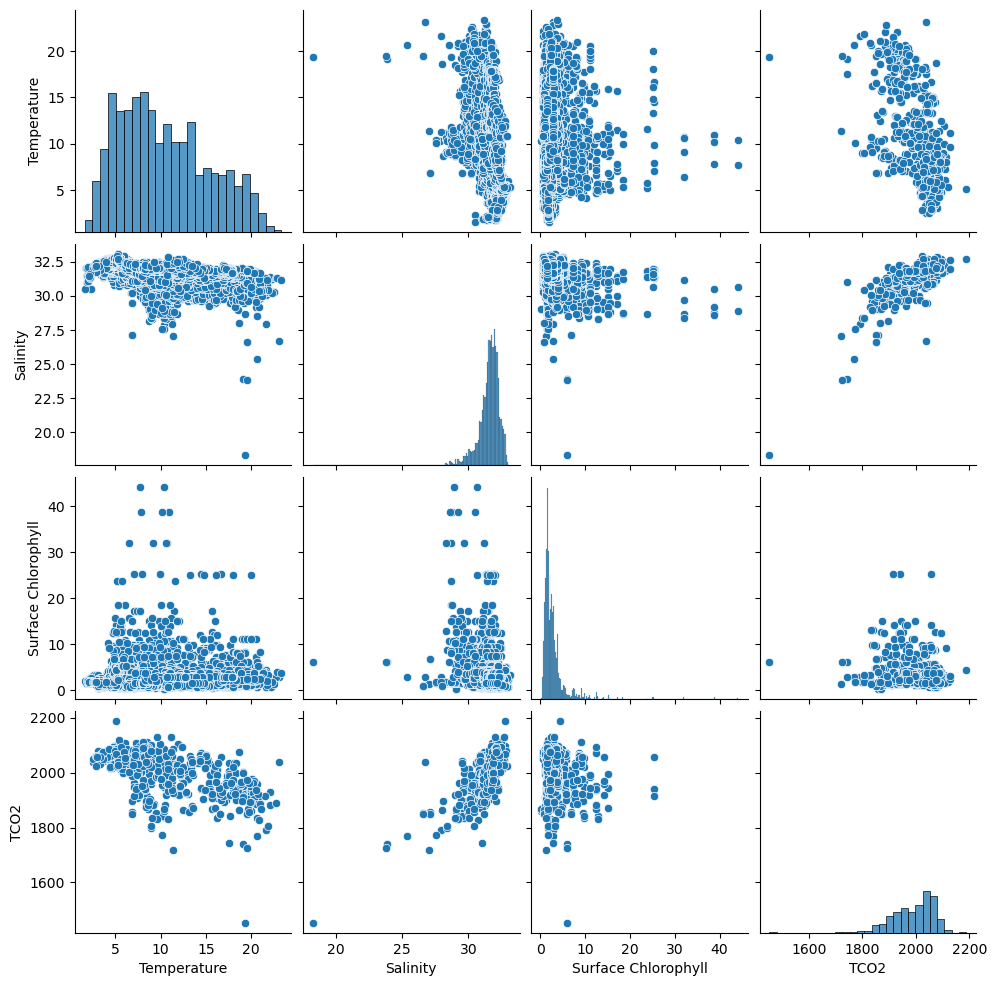

In [9]:
sns.pairplot(df[['Temperature', 'Salinity', 'Surface Chlorophyll', 'TCO2']])
plt.show()

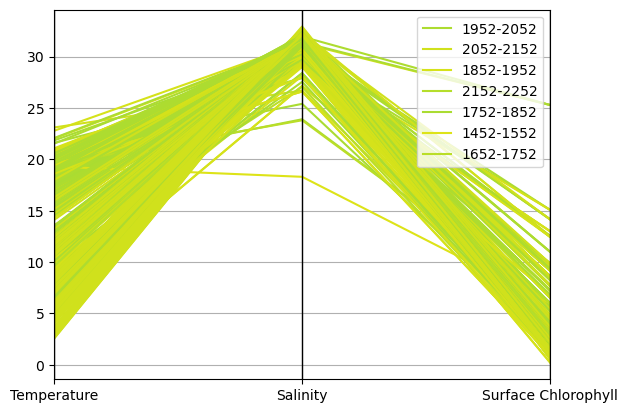

In [10]:
df2 = df.copy()
for r in ['Temperature', 'Salinity', 'Surface Chlorophyll', 'TCO2']:
    df2 = df2[~np.isnan(df2[r])]

chunk = 100
bin_labels = [f'{i}-{i+chunk}' for i in range(int(df2['TCO2'].min()), 
                                           int(df2['TCO2'].max()), 
                                           chunk)]
df2['Binned TCO2'] = pd.cut(df2['TCO2'], bins=len(bin_labels), labels=bin_labels)

parallel_coordinates(df2[['Temperature', 'Salinity', 'Surface Chlorophyll', 'Binned TCO2']], 'Binned TCO2', color=plt.cm.viridis(df2['TCO2'] / max(df2['TCO2'])))
plt.show()

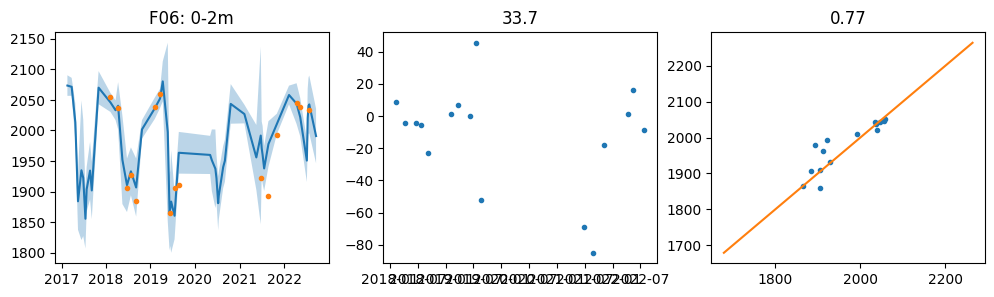

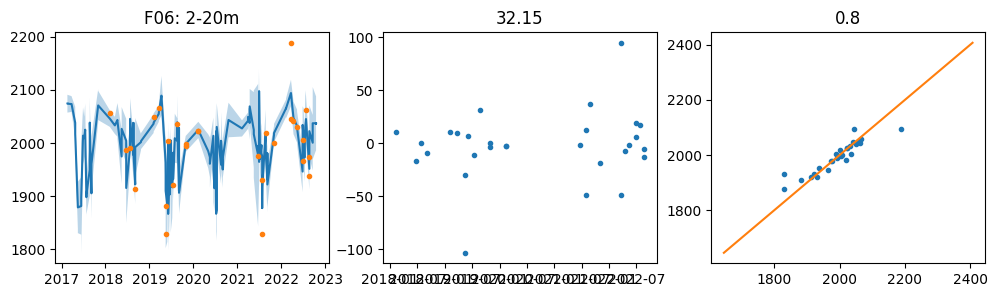

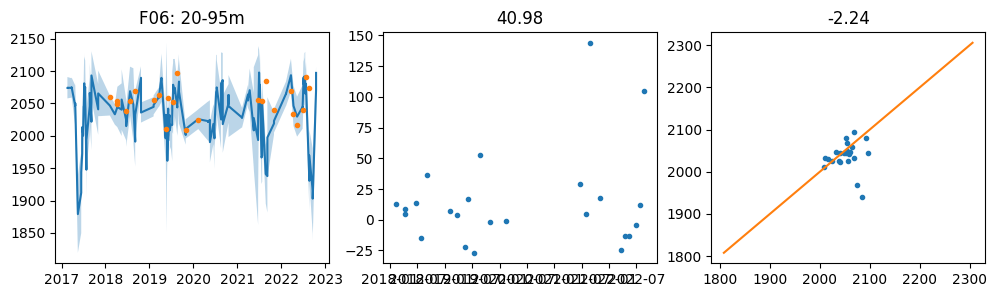

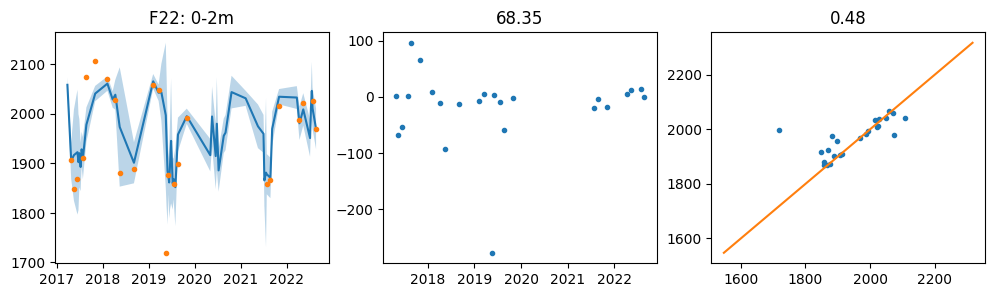

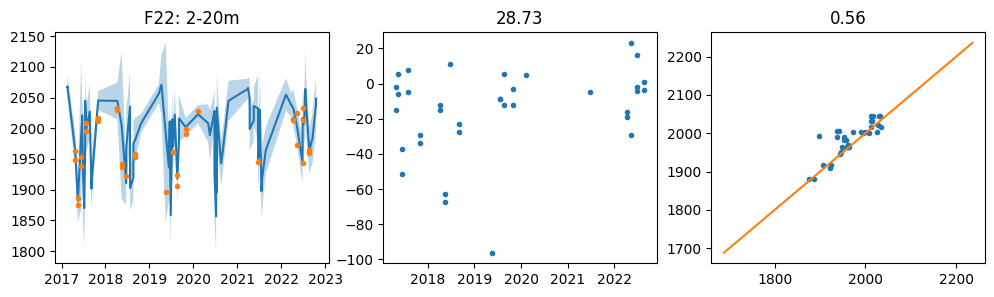

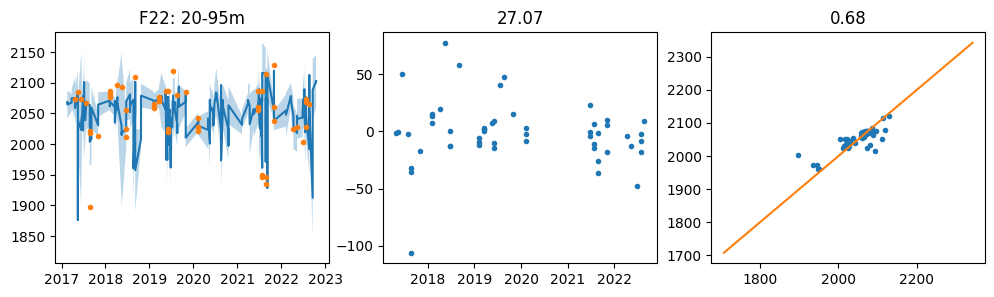

In [18]:
depths = [[0,2],[2,20],[20,95]]

for s in ['F06', 'F22']:
    df_s = df[df['Station']==s]
    for k, d in enumerate(depths):
        df_d = df_s[(df_s['Depth'] >= d[0]) & (df_s['Depth'] < d[1])]

        plt.figure(figsize=(12,3))
        plt.subplot(1,3,1)
        plt.plot(df_d['Date'],df_d[v+' (Prediction)'])
        plt.fill_between(df_d['Date'],df_d[v+' (Prediction)']+1.96*df_d[v+' (Std. Dev.)'],df_d[v+' (Prediction)']-1.96*df_d[v+' (Std. Dev.)'], alpha=0.3)
        plt.plot(df_d['Date'],df_d[v], '.' )
        plt.title(s+': '+str(d[0])+'-'+str(d[1])+'m')

        plt.subplot(1,3,2)
        plt.plot(df_d['Date'],df_d[v]-df_d[v+' (Prediction)'], '.' )
        rmse = np.round(np.sqrt(np.nanmean(np.square(df_d[v]- df_d[v+' (Prediction)']))),2)
        r2 = np.round(r2_score(df_d[~df_d[v].isna()][v],df_d[~df_d[v].isna()][v+' (Prediction)']),2)
        plt.title(rmse)

        plt.subplot(1,3,3)
        plt.plot(df_d[v], df_d[v+' (Prediction)'], '.' )
        xline = np.arange(0.9*df_d[v].min(),1.1*df_d[v].max())
        plt.plot(xline, xline)
        plt.title(r2)

In [12]:
# df.to_csv('../Data/MWRA_DIC.csv', index=False)